In [1]:
from sklearn import datasets, linear_model, metrics, preprocessing, svm
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from math import e
import pandas as pd

In [2]:
##### ustawienia
time_multiplicator = 1
seed = 244810
#samples = 2410
samples = 300

In [3]:
X, y  = datasets.make_classification(n_features=2,n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed, class_sep=2 )

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
def standarize(arr):
    for col in range(arr.shape[1]):
        xmean = np.mean( arr[:,col])
        xstd = np.std( arr[:,col])
        arr[:,col] = (arr[:,col] - xmean)/xstd
    return arr    
    
def normalize(arr):
    for col in range(arr.shape[1]):
        xmin = min( arr[:,col])
        xmax = max( arr[:,col])
        arr[:,col] = (arr[:,col] - xmin )/(xmax-xmin)
    
    return arr        
    
X_train = normalize(X_train)
X_test = normalize(X_test)

#X_train = standarize(X_train)
#X_test = standarize(X_test)

In [6]:
y_train[y_train == 0] =-1
y_test[y_test == 0] =-1

In [7]:
class mysvm:
    def __init__(self, C=1.0, kernel='rbf', sigma=0.1, degree=2):
        self.C = C
        if kernel == 'poly':
            self.kernel = self.polynomial
            self.degree = degree
        if kernel == 'linear':
            self.kernel = self.polynomial
            self.degree = 1
            
        else:
            self.kernel = self.rbf
            self.sigma = sigma
            
        self.X = None
        self.y = None
        self.alpha = None
        self.b = 0
        self.ones = None
        self.y_iy_jk_ij=None
    
    def rbf(self, X1, X2):
         return np.exp(-(self.sigma) * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)
        #return np.exp(-(1 / self.sigma ** 2) * np.linalg.norm(X1[:, np.newaxis] - X2[np.newaxis, :], axis=2) ** 2)

    def polynomial(self, X1, X2):
        return (1 + X1.dot(X2.T)) ** self.degree
    
    def cost(self, x):
        return -(np.sum(x) - 0.5 * np.sum(np.outer(x, x) * self.y_iy_jk_ij))
    
    def fit(self, X, y, lr=2e-4, epochs=500):
        self.X = X
        self.y = y

        self.alpha = np.random.random(X.shape[0])
        self.b = 0
        
        self.ones = np.ones(X.shape[0])

        self.y_iy_jk_ij = np.outer(y, y) * self.kernel(X, X)

        losses = []
        
        res = scipy.optimize.fmin_cg(self.cost, self.alpha)
        self.alpha = res

        index = np.where((self.alpha) > 0 & (self.alpha < self.C))[0]

        b_i = y[index] - (self.alpha * y).dot(self.kernel(X, X[index]))

        self.b = np.mean(b_i)

    def decision_function(self, X):
        return (self.alpha * self.y).dot(self.kernel(self.X, X)) + self.b
    
    def predict(self, X):
        return np.sign(self.decision_function(X))

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)


In [8]:
def compare_model(sk, my,X_tr, X_te, y_tr, y_te ):
    sk_time = time.perf_counter()
    for i in range(time_multiplicator):
        sk.fit(X_tr,y_tr)
    sk_time = (time.perf_counter() - sk_time)/time_multiplicator

    my_time = time.perf_counter()
    for i in range(time_multiplicator):
        my.fit(X_tr,y_tr)
    my_time = (time.perf_counter() - my_time)/time_multiplicator
    
    my_pred = my.predict(X_te)
    sk_pred = sk.predict(X_te)
    
    #graph
    fig, axs = plt.subplots(3, 2,figsize=(12,18))

    mesh = np.meshgrid(np.arange(0, 1.1, 0.01), np.arange(0, 1.1, 0.01))[0]
    sk_predict = sk.predict(np.c_[mesh.ravel(), mesh.T.ravel()]).reshape(mesh.shape)
    my_predict = np.array(my.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)
    
    axs[0,0].set_title("Sklearn")
    axs[0,0].contourf(mesh, mesh.T, sk_predict, alpha=0.2)
    axs[0,0].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
    axs[0,0].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)

    axs[0,1].set_title("Własna implementacja")
    axs[0,1].contourf(mesh, mesh.T, my_predict, alpha=0.2)
    axs[0,1].scatter(X_te[:, 0], X_te[:, 1], c=y_te, marker="o", alpha=0.5)
    axs[0,1].scatter(X_tr[:, 0], X_tr[:, 1], c=y_tr, marker="+", alpha=0.2)
    
    #confusion matrix
    sk_cm = metrics.confusion_matrix(y_te, sk_pred)
    sk_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=sk_cm)
    sk_disp.plot(ax=axs[1,0] ,cmap='plasma')
    sk_disp.im_.colorbar.remove()

    my_cm = metrics.confusion_matrix(y_te, my_pred)
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[1,1] ,cmap='plasma')
    my_disp.im_.colorbar.remove()
    my_disp.ax_.set_ylabel('')

    #roc
    fpr, tpr, thresholds = metrics.roc_curve(y_te, sk.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Sklearn')
    display.plot(ax=axs[2,0])

    fpr, tpr, thresholds = metrics.roc_curve(y_te, my.decision_function(X_test))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[2,1])
    
    #metryki
    print('              | Sklearn | Własna')
    print('--------------+---------+----------')
    print(f'Czułość       |{sk_cm[0][0]/(sk_cm[0][0]+sk_cm[1][0]):9.4f}|{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):.4f}')
    print(f'Specyficzność |{sk_cm[1][1]/(sk_cm[0][0]+sk_cm[1][1]):9.4f}|{my_cm[1][1]/(my_cm[0][0]+my_cm[1][1]):.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(sk_pred, y_test):9.4f}|{metrics.accuracy_score(my_pred, y_test):.4f}')
    print(f'Czas wykonania|{sk_time:9.2E}|{my_time:.2E}')
    print(f'BACC          |{metrics.balanced_accuracy_score(sk_pred, y_test,adjusted=False):9.4f}|{metrics.balanced_accuracy_score(my_pred, y_test,adjusted=False):.4f}')
        
    
    

In [9]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.1, random_state=seed)

M_train, M_test, mc_train, mc_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)
mc_train[mc_train == 0] =-1
mc_test[mc_test == 0] =-1
M_train = normalize(M_train)
M_test = normalize(M_test)


### Porównanie modeli liniowych

         Current function value: -138097.335948
         Iterations: 41
         Function evaluations: 34233
         Gradient evaluations: 142
              | Sklearn | Własna
--------------+---------+----------
Czułość       |   1.0000|1.0000
Specyficzność |   0.5167|0.5167
Skuteczność   |   1.0000|1.0000
Czas wykonania| 1.67E-03|3.90E+00
BACC          |   1.0000|1.0000


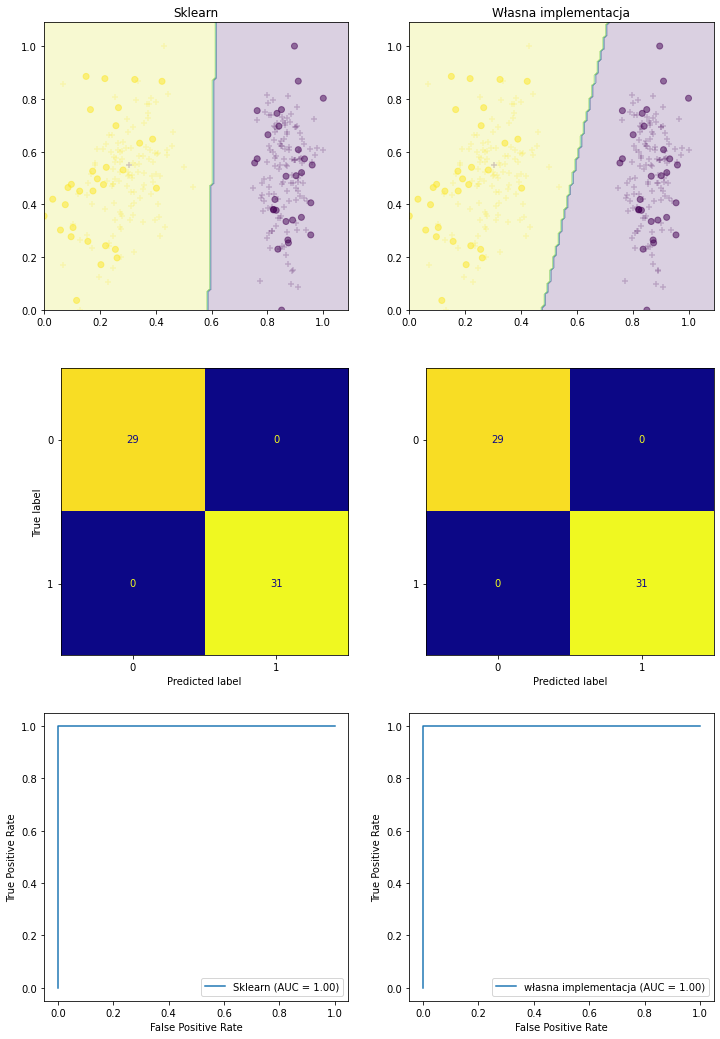

In [10]:
my11 = mysvm(kernel='linear', C=0.7)
sk11 = svm.SVC(kernel='linear')
compare_model(sk11, my11,X_train, X_test, y_train, y_test)

         Current function value: -302808.841987
         Iterations: 28
         Function evaluations: 23385
         Gradient evaluations: 97
              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.8387|0.5588
Specyficzność |   0.5094|0.4722
Skuteczność   |   0.4333|0.4833
Czas wykonania| 1.51E-03|2.51E+00
BACC          |   0.4338|0.4853


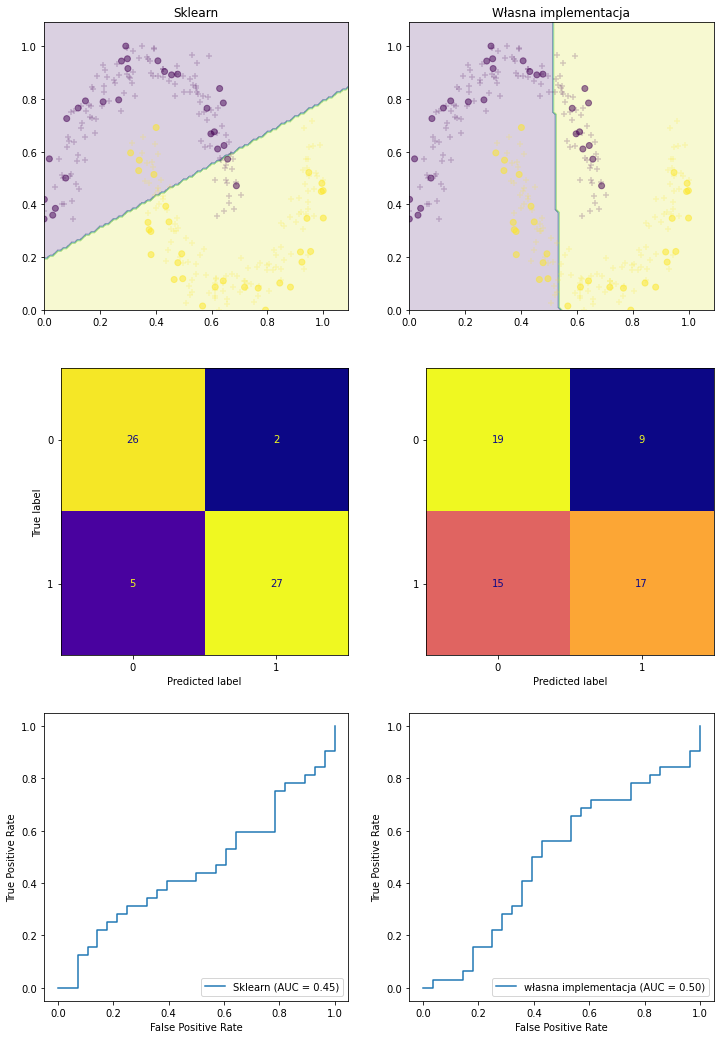

In [11]:
my12 = mysvm(kernel='linear', C=0.7)
sk12 = svm.SVC(kernel='linear')
compare_model(sk12, my12,M_train, M_test, mc_train, mc_test)

### Porównanie modeli RBF

         Current function value: -59601.513139
         Iterations: 69
         Function evaluations: 50140
         Gradient evaluations: 208
              | Sklearn | Własna
--------------+---------+----------
Czułość       |   1.0000|0.5000
Specyficzność |   0.5167|0.3871
Skuteczność   |   1.0000|0.5167
Czas wykonania| 2.05E-03|5.42E+00
BACC          |   1.0000|0.5227


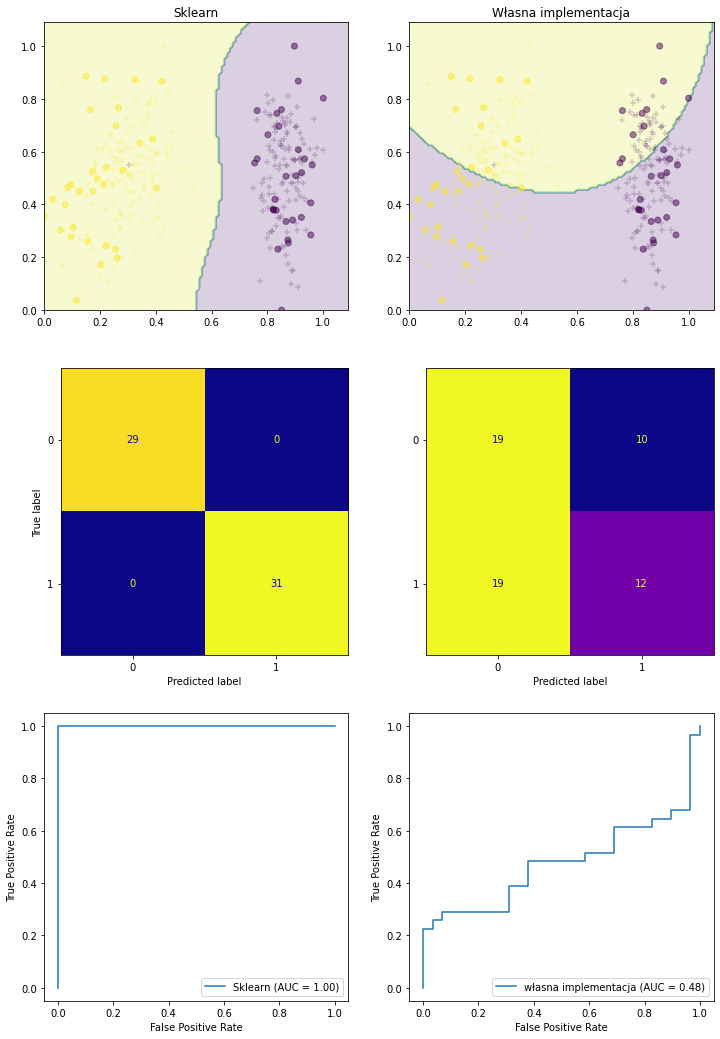

In [12]:
my21 = mysvm(kernel='rbf', C=1)
sk21 = svm.SVC(kernel='rbf')
compare_model(sk21, my21,X_train, X_test, y_train, y_test)

         Current function value: -325547.004256
         Iterations: 59
         Function evaluations: 47248
         Gradient evaluations: 196
              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.9655|0.8077
Specyficzność |   0.5254|0.5625
Skuteczność   |   0.4333|0.5167
Czas wykonania| 1.78E-03|4.79E+00
BACC          |   0.4327|0.5147


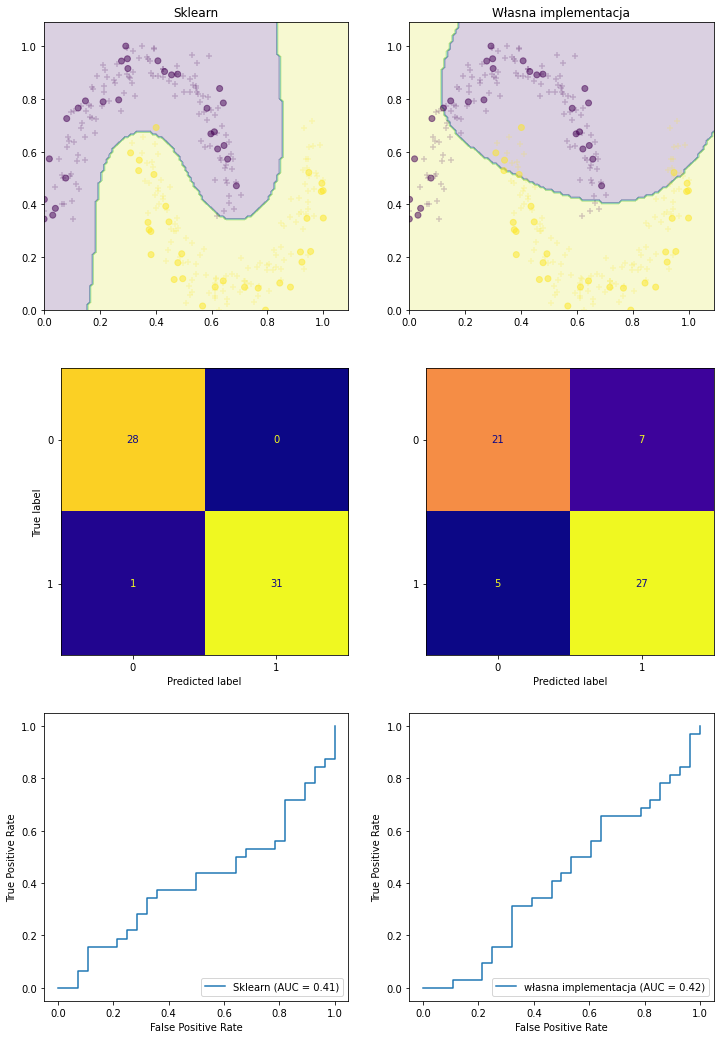

In [13]:
my22 = mysvm(kernel='rbf')
sk22 = svm.SVC(kernel='rbf')

compare_model(sk22, my22,M_train, M_test, mc_train, mc_test)

### Porównanie modeli wielomianowych 3 stopnia

         Current function value: -41136.252903
         Iterations: 332
         Function evaluations: 195704
         Gradient evaluations: 812
              | Sklearn | Własna
--------------+---------+----------
Czułość       |   1.0000|1.0000
Specyficzność |   0.5167|0.5167
Skuteczność   |   1.0000|1.0000
Czas wykonania| 1.24E-03|1.91E+01
BACC          |   1.0000|1.0000


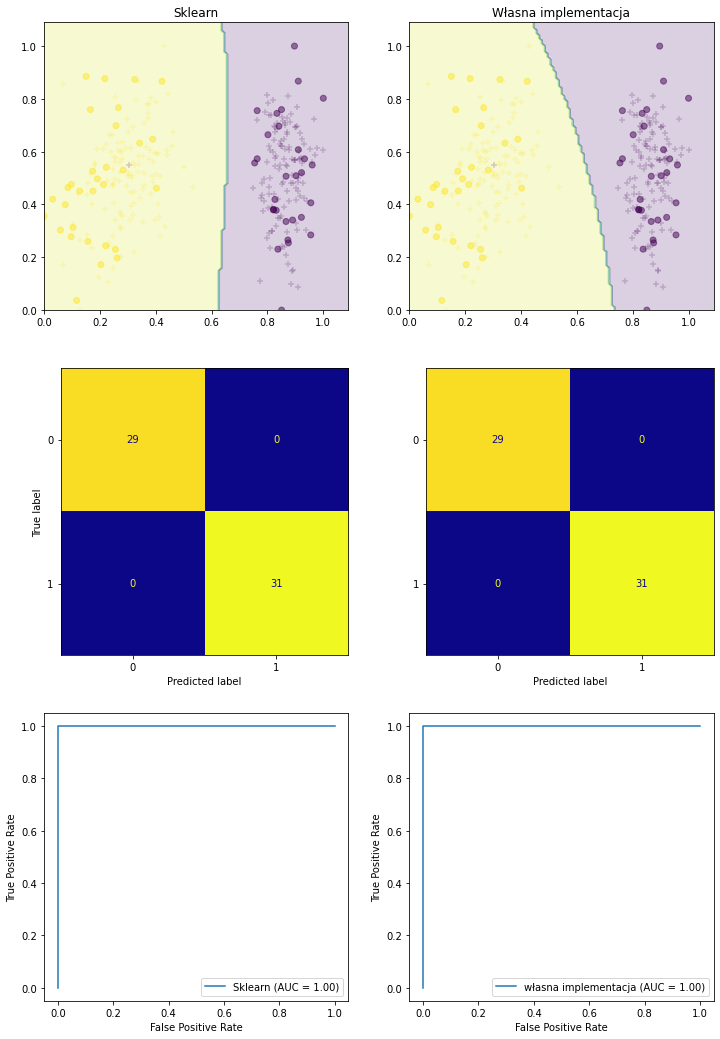

In [14]:
my31 = mysvm(kernel='poly', degree=3)
sk31 = svm.SVC(kernel='poly', degree=3)
compare_model(sk31, my31,X_train, X_test, y_train, y_test)

         Current function value: -455445.849566
         Iterations: 5
         Function evaluations: 22184
         Gradient evaluations: 92
              | Sklearn | Własna
--------------+---------+----------
Czułość       |   0.8333|0.5116
Specyficzność |   0.5192|0.3333
Skuteczność   |   0.4833|0.4333
Czas wykonania| 2.69E-03|2.18E+00
BACC          |   0.4833|0.4268


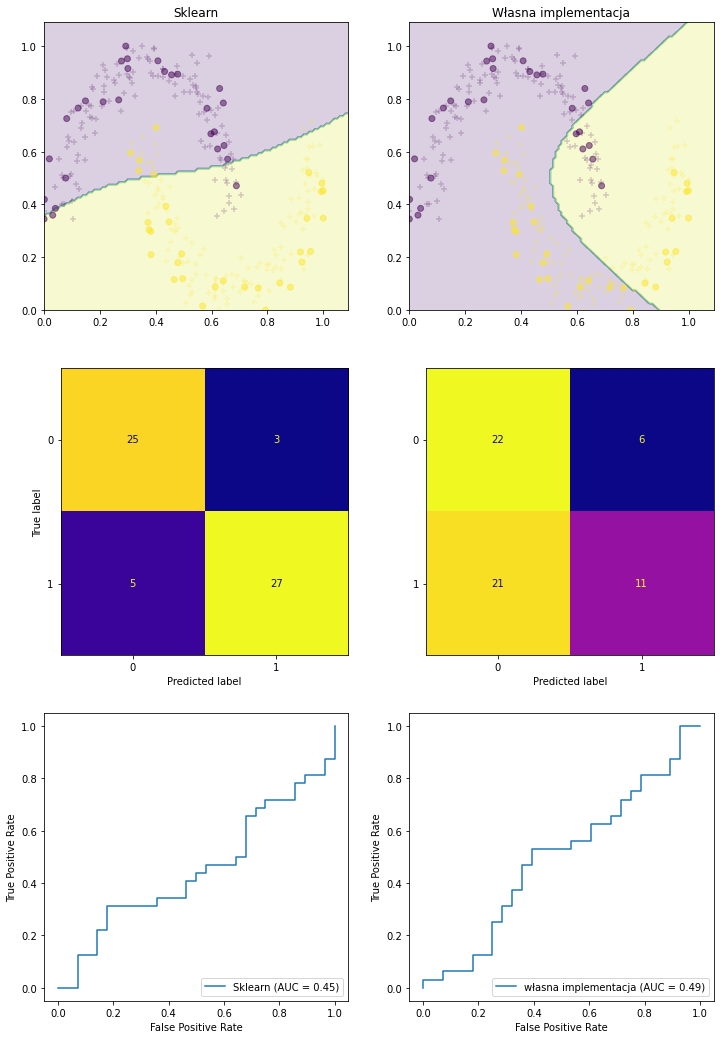

In [15]:
my32 = mysvm(kernel='poly', degree=3)
sk32 = svm.SVC(kernel='poly', degree=3)
compare_model(sk32, my32,M_train, M_test, mc_train, mc_test)

# Stellar Classification Dataset

In [16]:
stellar = pd.read_csv('star_classification.csv', delimiter = ',')

In [17]:
# usunięcie kolumn
stellar.drop(['obj_ID','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','MJD','fiber_ID'],inplace=True, axis=1)
stellar

,alpha,delta,u,g,r,i,z,class,redshift,plate
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121
...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000,9374
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895,7626
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366,2764
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040,6751


In [18]:
#zamiana na wartości liczbowe
stellar['class'] = stellar['class'].replace(['GALAXY'],0)
stellar['class'] = stellar['class'].replace(['QSO'],0)
stellar['class'] = stellar['class'].replace(['STAR'],1)

In [19]:
stellar['class'].value_counts()

0    78406
1    21594
Name: class, dtype: int64

In [20]:
#normalizacja
from sklearn import preprocessing
x = stellar.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

stellar = pd.DataFrame(data=df.values, columns=stellar.columns)
stellar = stellar.sort_values(by='class')


In [21]:
X = stellar.drop(columns='class')
y = stellar['class']

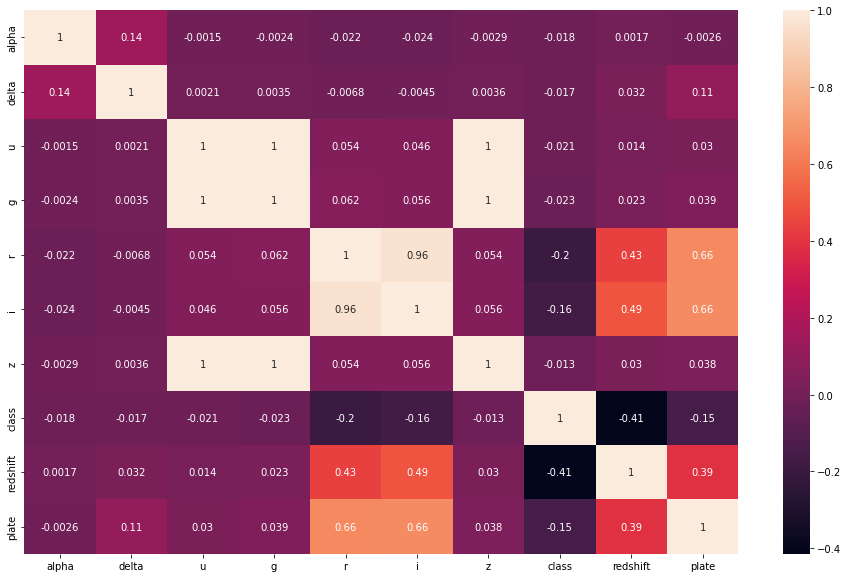

In [22]:
import seaborn as sn
plt.figure(figsize = (16,10))
sn.heatmap(stellar.corr(),annot=True, )
plt.show()

In [23]:
import math
corr = stellar.corr()['class']
corr = corr.abs()
corr.sort_values(ascending=False)

class       1.000000
redshift    0.414245
r           0.197722
i           0.161545
plate       0.150934
g           0.022780
u           0.021321
alpha       0.018461
delta       0.017011
z           0.013206
Name: class, dtype: float64

In [24]:
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=0)

In [25]:
X = np.array(X)
y = np.array(y)
y

array([0., 0., 0., ..., 1., 1., 1.])

In [26]:
from sklearn.model_selection import GridSearchCV
parameters =  [{'C': [1, 10, 100], 'kernel': ['linear']},
              {'C': [1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
              {'C': [1, 10, 100], 'degree': [1,2,3,4], 'kernel': ['poly']},]
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100], 'degree': [1, 2, 3, 4],
                          'kernel': ['poly']}])

In [27]:
clf.best_estimator_

SVC(C=100, kernel='poly')

In [28]:
stellarsvc = svm.SVC(kernel='poly', C=100)
stellarsvc.fit(X_train,y_train)

SVC(C=100, kernel='poly')

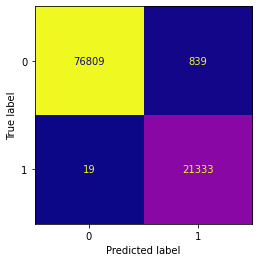

In [29]:
pred = stellarsvc.predict(X_test,)
cm = metrics.confusion_matrix(y_test, pred)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='plasma')
disp.im_.colorbar.remove()

### Wnioski
0-galaktyka 1- gwiazda,
dużo galaktyk zostało zaklasyfikowanych jako gwiazdy(839)
kilka gwiazd zostało zaklasyfikowanych jako galaktyka(19)

jeśli chcemy szukać galaktyk taki klasyfikator sprawi że rzadko będzimey rozwarzać gwiazd jako galaktyk ale stracimy też galaktyki które potencjalnie moglibyćmy badać